# 01 - Syllable Duration Distribution Figures

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import avn.dataloading as dataloading
import avn.segmentation
import avn.syntax as syntax
import matplotlib.pyplot as plt

In [2]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [3]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [4]:
dataloading.SongFile = SongFile

## Load Bird Data

In [5]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Syllable Durations

### Ground Truth

In [6]:
from scipy.stats import entropy
all_shan = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load ground truth
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    true_seg_table = pd.read_csv(ground_truth_path)
    true_seg_table = true_seg_table[true_seg_table.labels == 's']

    true_seg_table['Syll_dur'] = true_seg_table.offsets - true_seg_table.onsets

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(true_seg_table.Syll_dur / 1000), density=True, bins = bins)
    true_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_true' : [true_entropy], 
                             "Bird_ID" : Bird_ID})
    
    all_shan = pd.concat([all_shan, curr_shan])

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Us

In [7]:
all_shan.head(3)

,entropy_true,Bird_ID
0,0.696680,B145
0,0.772177,B236
0,0.551390,B258


### Whisper Seg

In [10]:
w_all_shan = pd.DataFrame()
for Bird_ID in All_Birds:

    #load wseg segmentations
    wseg_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                             'offset' : 'offsets', 
                                                             'file' : 'files'})
    wseg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
    wseg_data.seg_table["Syll_dur"] = (wseg_data.seg_table.offsets - wseg_data.seg_table.onsets)*1000
    wseg_data.seg_table['method'] = "Whisper Segmentation"

    bins = np.linspace(-2.5, 0, 50)
    density, __ = np.histogram(np.log10(wseg_data.seg_table.Syll_dur / 1000), density=True, bins = bins)
    wseg_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'entropy_wseg' : [wseg_entropy], 
                             "Bird_ID" : Bird_ID})
    
    w_all_shan = pd.concat([w_all_shan, curr_shan])

In [11]:
w_all_shan.head(3)

,entropy_wseg,Bird_ID
0,0.631623,B145
0,0.731460,B236
0,0.511742,B258


In [14]:
combo_all_shan = pd.merge(w_all_shan, all_shan, on = 'Bird_ID')
combo_all_shan.head(3)

,entropy_wseg,Bird_ID,entropy_true
0,0.631623,B145,0.696680
1,0.731460,B236,0.772177
2,0.511742,B258,0.551390


In [15]:
combo_all_shan.to_csv('wseg_and_manual_syllable_duration_distribution_entropies.csv')

### Plot Correlation 

In [16]:
combo_all_shan = pd.read_csv('wseg_and_manual_syllable_duration_distribution_entropies.csv').drop(columns = 'Unnamed: 0')

In [17]:
plt.rcParams.update({'font.size': 8})

<Figure size 300x300 with 0 Axes>

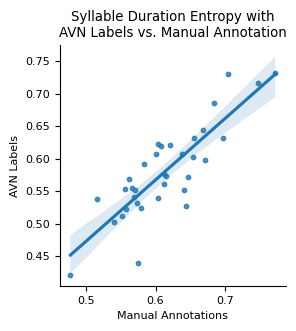

In [25]:
plt.figure(figsize = (3, 3))
sns.lmplot(data = combo_all_shan, x = 'entropy_true', y = 'entropy_wseg', height = 3, aspect = 1, scatter_kws={"s": 10})
plt.xlabel('Manual Annotations')
plt.ylabel('AVN Labels')
plt.title('Syllable Duration Entropy with\nAVN Labels vs. Manual Annotation')
plt.savefig('avn_vs_manual_syllable_duration_entropy.svg', transparent = True)

In [13]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [14]:
# linear regression to get slope and r^2
reg = LinearRegression().fit( combo_all_shan['entropy_true'][:, np.newaxis],  combo_all_shan['entropy_wseg'])
print(reg.score( combo_all_shan['entropy_true'][:, np.newaxis],  combo_all_shan['entropy_wseg']))

0.7146477297587196


C:\Users\tkoch\AppData\Local\Temp\ipykernel_27940\1048439090.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reg = LinearRegression().fit( combo_all_shan['entropy_true'][:, np.newaxis],  combo_all_shan['entropy_wseg'])
C:\Users\tkoch\AppData\Local\Temp\ipykernel_27940\1048439090.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(reg.score( combo_all_shan['entropy_true'][:, np.newaxis],  combo_all_shan['entropy_wseg']))


In [15]:
pearsonr(combo_all_shan['entropy_true'], combo_all_shan['entropy_wseg'])

PearsonRResult(statistic=0.8453683988408365, pvalue=1.664603700933323e-10)

## Gap Duration

### Whisper Seg

In [26]:
bin_dur = 10

In [27]:
from scipy.stats import entropy
w_all_shan_gap = pd.DataFrame()

for Bird_ID in All_Birds[:]:

    #load whisper-seg predictions
    segmentations_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
    predictions_wseg = pd.read_csv(segmentations_path)
    predictions_reformat = predictions_wseg.rename(columns = {'onset' : 'onsets', 
                                                'offset' : 'offsets',
                                                'file' : 'files'})

    predictions_reformat['labels'] = 's'
    
    song_folder_path = 'D:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' 

    syntax_data = syntax.SyntaxData(Bird_ID, predictions_reformat)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'wseg_gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    w_all_shan_gap = pd.concat([w_all_shan_gap, curr_shan])

In [29]:
w_all_shan_gap.head(3)

,wseg_gap_duration_entropy,Bird_ID
0,0.650696,B145
0,0.890905,B236
0,0.726944,B258


### Ground Truth

In [30]:
all_shan_gap = pd.DataFrame()
for Bird_ID in All_Birds:

    #load ground truth
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

    true_seg_table = pd.read_csv(ground_truth_path)
    true_seg_table = true_seg_table[true_seg_table.labels == 's']

    song_folder_path = 'D:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' 

    #convert timestamps from milliseconds to seconds
    true_seg_table['onsets'] = true_seg_table['onsets'] / 1000
    true_seg_table['offsets'] = true_seg_table['offsets'] / 1000
    
    #remove .not.mat file extension from file names in file column
    true_seg_table['files'] = true_seg_table['files'].str.split(pat = '.not', n = 1).str[0]

    syntax_data = syntax.SyntaxData(Bird_ID, true_seg_table)
    syntax_data.add_file_bounds(song_folder_path)
    gaps_df = syntax_data.get_gaps_df()

    #select only gaps less than 200ms, as longer likely reflect inter-motif gaps
    gaps_df = gaps_df[gaps_df.durations < 0.2]
    #convert from s to ms
    gaps_df.durations = gaps_df.durations*1000

    bins = np.arange(0, 200, bin_dur)
    density, __ = np.histogram(gaps_df.durations, density=True, bins = bins)
    gap_entropy = entropy(density) / np.log(len(bins))

    curr_shan = pd.DataFrame({'gap_duration_entropy' : [gap_entropy],
                             "Bird_ID" : Bird_ID})
    
    all_shan_gap = pd.concat([all_shan_gap, curr_shan])

In [86]:
all_shan_gap.head(3)

,gap_duration_entropy,Bird_ID
0,0.718393,B145
0,0.929563,B236
0,0.780869,B258


### Plot Correlation 

In [31]:
combo_all_shan = pd.merge(w_all_shan_gap, all_shan_gap, on = 'Bird_ID')
combo_all_shan.head(3)

,wseg_gap_duration_entropy,Bird_ID,gap_duration_entropy
0,0.650696,B145,0.718393
1,0.890905,B236,0.929563
2,0.726944,B258,0.780869


In [32]:
combo_all_shan.to_csv('wseg_and_manual_gap_duration_distribution_entropies.csv')

In [11]:
plt.rcParams.update({'font.size': 8})

<Figure size 400x400 with 0 Axes>

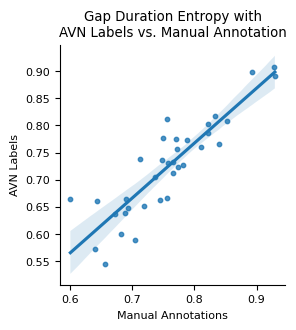

In [34]:
plt.figure(figsize = (4, 4))
sns.lmplot(data = combo_all_shan, x = 'gap_duration_entropy', y = 'wseg_gap_duration_entropy', height = 3, aspect = 1, scatter_kws={"s": 10} )
plt.xlabel('Manual Annotations')
plt.ylabel('AVN Labels')
plt.title('Gap Duration Entropy with\nAVN Labels vs. Manual Annotation')
plt.savefig('avn_vs_manual_gap_duration_entropy.svg', transparent = True)

In [90]:
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr

In [91]:
# linear regression to get slope and r^2
reg = LinearRegression().fit( combo_all_shan['gap_duration_entropy'][:, np.newaxis],  combo_all_shan['wseg_gap_duration_entropy'])
print(reg.score( combo_all_shan['gap_duration_entropy'][:, np.newaxis],  combo_all_shan['wseg_gap_duration_entropy']))

0.7789289628911368


C:\Users\tkoch\AppData\Local\Temp\ipykernel_28996\1987835917.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  reg = LinearRegression().fit( combo_all_shan['gap_duration_entropy'][:, np.newaxis],  combo_all_shan['wseg_gap_duration_entropy'])
C:\Users\tkoch\AppData\Local\Temp\ipykernel_28996\1987835917.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(reg.score( combo_all_shan['gap_duration_entropy'][:, np.newaxis],  combo_all_shan['wseg_gap_duration_entropy']))


In [92]:
pearsonr(combo_all_shan['gap_duration_entropy'], combo_all_shan['wseg_gap_duration_entropy'])

PearsonRResult(statistic=0.8825695229788624, pvalue=1.0988476774166647e-12)

## Example Syllable Duration Figure

### B447

In [35]:
Bird_ID = 'B447'

In [37]:
#load ground truth
ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

#load wseg segmentations
wseg_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

#create avn.SegData object
seg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
seg_data = avn.dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
seg_data.true_seg_table = seg_data.true_seg_table[seg_data.true_seg_table.labels == 's']

seg_data.seg_table["Syll_dur"] = (seg_data.seg_table.offsets - seg_data.seg_table.onsets)*1000
seg_data.seg_table['Segmentation Method'] = "WhisperSeg"
seg_data.true_seg_table['Syll_dur'] = (seg_data.true_seg_table.offsets - seg_data.true_seg_table.onsets)*1000
seg_data.true_seg_table['Segmentation Method'] = "Manual Annotation"

syll_durs = pd.concat([seg_data.true_seg_table, seg_data.seg_table])

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]


c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


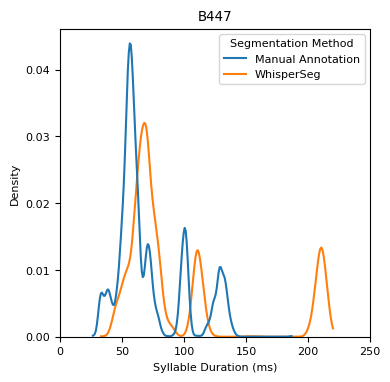

In [38]:
plt.figure(figsize = (4, 4))
sns.kdeplot(data = syll_durs.reset_index(), x = 'Syll_dur',  hue = 'Segmentation Method', common_norm=False, cut = 0, bw_adjust=0.5, clip = (0, 600), log_scale=False, 
            bw = 0.1)
plt.xlim(0, 250)
plt.xlabel("Syllable Duration (ms)")
plt.title(Bird_ID)
plt.show();

### O440

In [39]:
Bird_ID = 'O440'

In [40]:
#load ground truth
ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

#load wseg segmentations
wseg_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

#create avn.SegData object
seg_data = avn.segmentation.SegData(Bird_ID, wseg_segments)
seg_data = avn.dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
seg_data.true_seg_table = seg_data.true_seg_table[seg_data.true_seg_table.labels == 's']

seg_data.seg_table["Syll_dur"] = (seg_data.seg_table.offsets - seg_data.seg_table.onsets)*1000
seg_data.seg_table['Segmentation Method'] = "WhisperSeg"
seg_data.true_seg_table['Syll_dur'] = (seg_data.true_seg_table.offsets - seg_data.true_seg_table.onsets)*1000
seg_data.true_seg_table['Segmentation Method'] = "Manual Annotation"

syll_durs = pd.concat([seg_data.true_seg_table, seg_data.seg_table])

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]


c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


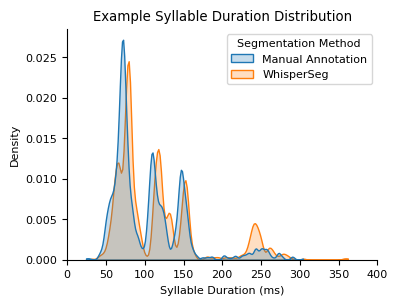

In [43]:
plt.figure(figsize = (4, 3))
sns.kdeplot(data = syll_durs.reset_index(), x = 'Syll_dur',  hue = 'Segmentation Method', common_norm=False, cut = 0, bw_adjust=0.5, clip = (0, 600), log_scale=False, 
            bw = 0.1, fill = True)
plt.xlim(0, 400)
plt.xlabel("Syllable Duration (ms)")
plt.title("Example Syllable Duration Distribution")
sns.despine()
plt.savefig('O440_syllable_duration_distribution.svg', transparent = True)

## Example Gap Duration Distributions

### O440

In [6]:
Bird_ID = 'O440'

In [9]:
#load ground truth
ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'

true_seg_table = pd.read_csv(ground_truth_path)
true_seg_table = true_seg_table[true_seg_table.labels == 's']

song_folder_path = 'D:\\Final_Bird_Dataset\\FP1_project_birds\\segmented_songs\\' 

#convert timestamps from milliseconds to seconds
true_seg_table['onsets'] = true_seg_table['onsets'] / 1000
true_seg_table['offsets'] = true_seg_table['offsets'] / 1000

#remove .not.mat file extension from file names in file column
true_seg_table['files'] = true_seg_table['files'].str.split(pat = '.not', n = 1).str[0]

syntax_data = syntax.SyntaxData(Bird_ID, true_seg_table)
syntax_data.add_file_bounds(song_folder_path)
gaps_df = syntax_data.get_gaps_df()

#select only gaps less than 200ms, as longer likely reflect inter-motif gaps
gaps_df = gaps_df[gaps_df.durations < 0.2]
#convert from s to ms
gaps_df.durations = gaps_df.durations*1000
gaps_df['Segmentation Method'] = 'Manual Annotation'


#load wseg segmentations
wseg_path = 'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID +  '_wseg.csv'
wseg_segments = pd.read_csv(wseg_path).rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
wseg_segments['labels'] = 's'

syntax_data = syntax.SyntaxData(Bird_ID, wseg_segments)
syntax_data.add_file_bounds(song_folder_path)
gaps_df_wseg = syntax_data.get_gaps_df()

#select only gaps less than 200ms, as longer likely reflect inter-motif gaps
gaps_df_wseg = gaps_df_wseg[gaps_df_wseg.durations < 0.2]
#convert from s to ms
gaps_df_wseg.durations = gaps_df_wseg.durations*1000
gaps_df_wseg['Segmentation Method'] = 'WhisperSeg'



gap_durs = pd.concat([gaps_df, gaps_df_wseg])

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


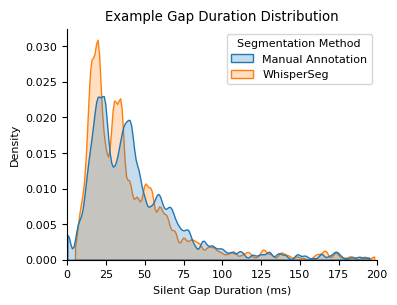

In [12]:
plt.figure(figsize = (4, 3))
sns.kdeplot(data = gap_durs.reset_index(), x = 'durations',  hue = 'Segmentation Method', common_norm=False, cut = 0, bw_adjust=0.5, clip = (0, 600), log_scale=False, 
            bw = 0.1, fill = True)
plt.xlim(0, 200)
plt.xlabel("Silent Gap Duration (ms)")
plt.title("Example Gap Duration Distribution")
sns.despine()
plt.savefig('O440_gap_duration_distribution.svg', transparent = True)